In [54]:
import torch, os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import segmentation_models_pytorch as smp
import cv2
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
checkpoint = torch.load('C:/Users/preme/vscode/crop_prediction/output/best_model.pth', map_location=device)
state_dict = checkpoint["model_state"]
model = smp.Unet(encoder_name='resnet34', classes=1)
model.load_state_dict(state_dict)
model.to(device)
model.eval()
img_dir = 'C:/Users/preme/vscode/crop_prediction/CoFly-WeedDB/CoFly-WeedDB/images'

In [9]:
def compute_exg(image):
    img = image.astype('float')
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    exg = 2 * G - R - B
    exg = (exg - exg.min()) / (exg.max() - exg.min() + 1e-8)
    return exg

def vegetation_mask_exg(image, threshold=0.4):
    exg = compute_exg(image)
    mask = (exg > threshold).astype('uint8') # crop + weed
    return mask, exg


In [17]:
def weed_mask_(img, model):
    img_resized = cv2.resize(img, (512, 512))
    tensor = torch.tensor(img_resized/255.).permute(2,0,1).unsqueeze(0).float().to(device)
    with torch.no_grad():
        logits = model(tensor)
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    mask = (prob > 0.5).astype(np.uint8)
    return mask
    

In [18]:
def extract_cover_features(image, weed_mask):
    veg_mask, exg = vegetation_mask_exg(image)
    total_px = veg_mask.size
    veg_cover = 100 * veg_mask.sum() / total_px
    weed_cover = 100 * weed_mask.sum() / total_px
    crop_cover = max(0.0, veg_cover - weed_cover)

    return veg_cover, weed_cover, crop_cover

In [19]:
results = []

for f in tqdm(os.listdir(img_dir)):
    if f.endswith('.jpg') or f.endswith('.png'):
        img_path = os.path.join(img_dir, f)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        weed_mask = weed_mask_(img, model)
        veg_cover, weed_cover, crop_cover = extract_cover_features(img, weed_mask)
        results.append({
            'field_id': os.path.splitext(f)[0],
            'veg_cover': veg_cover,
            'weed_cover': weed_cover,
            'crop_cover': crop_cover
         })
        
features_df = pd.DataFrame(results)
print(features_df.head())
features_df.to_csv('field_cover_features.csv', index=False)


100%|██████████| 366/366 [00:32<00:00, 11.42it/s]

                                            field_id  veg_cover  weed_cover  \
0  ID_00048_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....  40.243707         0.0   
1  ID_00049_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....  47.764431         0.0   
2  ID_00050_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....  44.197591         0.0   
3  ID_00051_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....  43.827040         0.0   
4  ID_00052_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....  38.511502         0.0   

   crop_cover  
0   40.243707  
1   47.764431  
2   44.197591  
3   43.827040  
4   38.511502  


In [26]:
features_df.head()

,field_id,veg_cover,weed_cover,crop_cover
0,ID_00048_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....,40.243707,0.0,40.243707
1,ID_00049_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....,47.764431,0.0,47.764431
2,ID_00050_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....,44.197591,0.0,44.197591
3,ID_00051_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....,43.827040,0.0,43.827040
4,ID_00052_UAV_dji.phantom.4.pro.hawk.1_[Lat=39....,38.511502,0.0,38.511502


In [34]:
features_df.describe()

,veg_cover,weed_cover,crop_cover
count,366.000000,366.000000,366.000000
mean,43.688246,0.252037,43.440443
std,8.578196,0.929487,8.784984
min,0.206163,0.000000,0.000000
25%,39.752414,0.000000,39.752414
50%,44.175998,0.000000,43.939941
75%,47.533149,0.000000,47.280273
max,99.633681,6.225260,99.633681


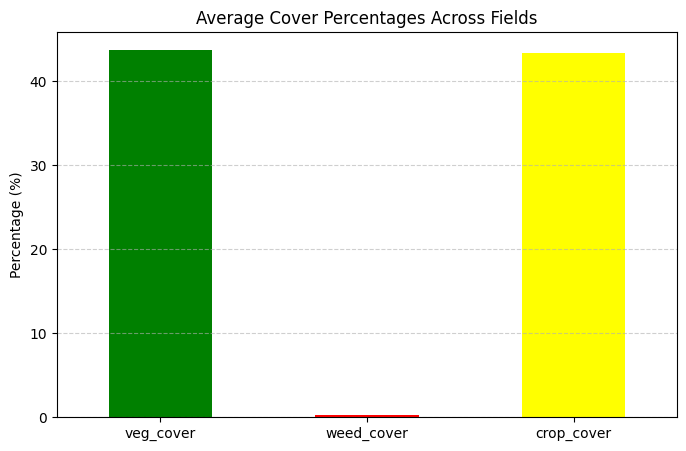

In [28]:
plt.figure(figsize=(8, 5))
features_df[['veg_cover', 'weed_cover', 'crop_cover']].mean().plot(kind='bar', color=['green', 'red', 'yellow'])
plt.title("Average Cover Percentages Across Fields")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


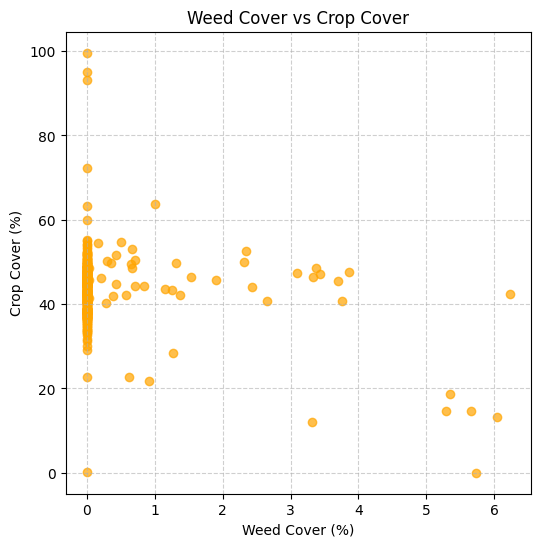

In [30]:
plt.figure(figsize=(6, 6))
plt.scatter(features_df['weed_cover'], features_df['crop_cover'], color='orange', alpha=0.7)
plt.title("Weed Cover vs Crop Cover")
plt.xlabel("Weed Cover (%)")
plt.ylabel("Crop Cover (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Stacked ensemble or fusion model

In [73]:
yield_df = pd.read_csv('C:/Users/preme/vscode/yield prediction/yield_df.csv')
yield_df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [74]:
X_env = yield_df[['avg_temp', 'pesticides_tonnes', 'average_rain_fall_mm_per_year']]
y = yield_df['hg/ha_yield']

X_train, X_test, y_train, y_test = train_test_split(X_env, y, test_size=0.2, random_state=42)

model_env = LGBMRegressor(n_estimators=300, learning_rate=0.05)
model_env.fit(X_train, y_train)

env_preds = model_env.predict(X_env)
yield_df['yield_env_pred'] = env_preds
yield_df['yield_env_pred'] = yield_df['yield_env_pred'] / 10000

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 22593, number of used features: 3
[LightGBM] [Info] Start training from score 77051.197760


In [86]:
import joblib
import os

os.makedirs("models", exist_ok=True)  # create folder if not exists
joblib.dump(model_env, "models/yield_env_model.txt")

['models/yield_env_model.txt']

In [75]:
yield_df['yield_env_pred']

0        3.748584
1        3.748584
2        3.748584
3        3.748584
4        3.748584
           ...   
28237    5.183907
28238    5.183907
28239    5.183907
28240    5.183907
28241    5.183907
Name: yield_env_pred, Length: 28242, dtype: float64

In [76]:
features_df["yield_value"] = (
    0.6 * features_df["crop_cover"] -
    0.3 * features_df["weed_cover"] +
    0.1 * features_df["veg_cover"]
)
features_df["yield_value"] = features_df["yield_value"].clip(lower=0)
features_df["yield_value"] /= features_df["yield_value"].max()  # scale 0–1
features_df["yield_value"] *= 5  # scale to 0–5 tons/ha (example)


In [81]:
crop = "Maize"
yield_df = yield_df[yield_df["Item"] == crop]
yield_df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,yield_env_pred
0,Albania,Maize,1990,36613,1485.0,121.0,16.37,3.748584
6,Albania,Maize,1991,29068,1485.0,121.0,15.36,3.703446
12,Albania,Maize,1992,24876,1485.0,121.0,16.06,3.748584
18,Albania,Maize,1993,24185,1485.0,121.0,16.05,3.748584
23,Albania,Maize,1994,25848,1485.0,201.0,16.96,3.694727


In [82]:

X_canopy = features_df[['veg_cover', 'weed_cover', 'crop_cover']]
y = features_df['yield_value']  # only if you have yield labels for these fields!

X_train, X_test, y_train, y_test = train_test_split(X_canopy, y, test_size=0.2, random_state=42)

model_canopy = LGBMRegressor(n_estimators=300, learning_rate=0.05)
model_canopy.fit(X_train, y_train)

canopy_preds = model_canopy.predict(X_canopy)
features_df['yield_canopy_pred'] = canopy_preds


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 292, number of used features: 3
[LightGBM] [Info] Start training from score 2.187684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [85]:
# Normalize both lists to [0, 1]
canopy_norm = (features_df["yield_canopy_pred"] - features_df["yield_canopy_pred"].min()) / \
               (features_df["yield_canopy_pred"].max() - features_df["yield_canopy_pred"].min())

env_norm = (yield_df["yield_env_pred"] - yield_df["yield_env_pred"].min()) / \
            (yield_df["yield_env_pred"].max() - yield_df["yield_env_pred"].min())

# If they have different lengths, sample to match (just for combination)
min_len = min(len(canopy_norm), len(env_norm))
canopy_norm = canopy_norm.sample(min_len, random_state=42).reset_index(drop=True)
env_norm = env_norm.sample(min_len, random_state=42).reset_index(drop=True)

# Weighted combination (e.g., 60% canopy + 40% environment)
yield_combined = 0.6 * canopy_norm + 0.4 * env_norm

# Create combined DataFrame
hybrid_df = pd.DataFrame({
    "yield_canopy_pred": canopy_norm,
    "yield_env_pred": env_norm,
    "yield_final_pred": yield_combined
})

print(hybrid_df.head())


   yield_canopy_pred  yield_env_pred  yield_final_pred
0           0.642254        0.167566          0.452379
1           0.615805        0.381834          0.522217
2           0.560840        0.255188          0.438579
3           0.719287        0.448996          0.611170
4           0.596526        0.247104          0.456757


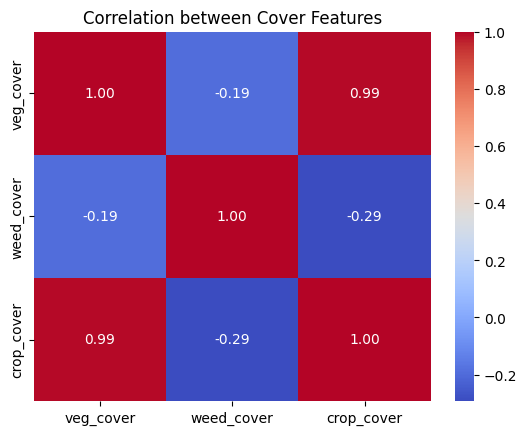

In [33]:
import seaborn as sns
corr = features_df[['veg_cover', 'weed_cover', 'crop_cover']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Cover Features")
plt.show()
